In [1]:
import sys
sys.path.append('../')

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np

from src.models.net import *
from src.si import *
from src.util import util as ut

/Users/giosuemigliorini/miniconda3/envs/cs274e/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = UNet(
    dim = 28,
    dim_mults = (1,2),
    flash_attn = True,
    channels=1,
    resnet_block_groups=4,
    attn_dim_head=16,
    attn_heads=2,
)

# model = SmallNet(dim=28)

si = LinearInterpolant(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, test_loader = ut.get_unlabeled_mnist_data()

In [3]:
num_params = [p.numel() for p in model.parameters()]
print('Number of parameters: ', sum(num_params))

Number of parameters:  568421


In [4]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 1
si.train(train_loader, optimizer, epochs,loss_type='velocity')

 14%|█▎        | 82/600 [02:25<15:17,  1.77s/it]


KeyboardInterrupt: 

In [5]:
x_initial = torch.randn(2, 1, 28, 28)

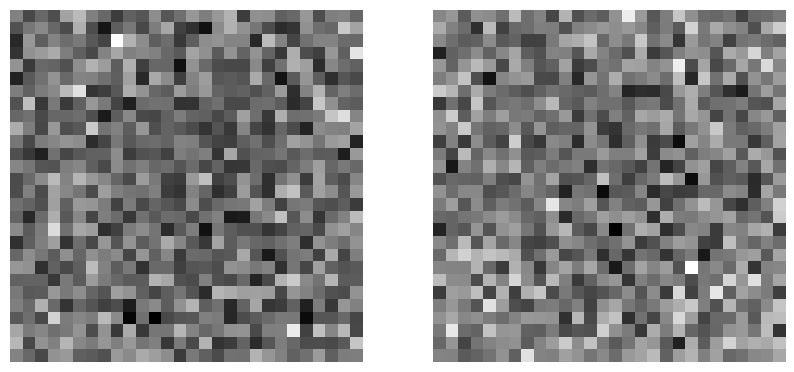

In [6]:
imgs = model(t=torch.tensor([1]) , x=x_initial)
# show the image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, img in enumerate(imgs):
    ax[i].imshow(img.squeeze().detach().numpy(), cmap='gray')
    ax[i].axis('off')

In [7]:
# class eta_to_b_model(torch.nn.Module):
#     def __init__(self, si):
#         super().__init__()
#         self.eta = si.model
#         self.a = si.a
#         self.b = si.b
#         self.da = si.da
#         self.db = si.db
#     def forward(self, t,x):
#         if t.dim() == 0:
#             t = t.unsqueeze(-1)
        
#         eta_out = self.eta(t,x)
#         return self.da(t)*eta_out + self.db(t)/self.b(t)*(x - self.a(t)* eta_out)

# b_model = eta_to_b_model(si)

In [8]:
# imgs = b_model(t=torch.tensor([0.001]) , x=x_initial)
# # show the image
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# for i, img in enumerate(imgs):
#     ax[i].imshow(img.squeeze().detach().numpy(), cmap='gray')
#     ax[i].axis('off')

In [9]:

n_eval = 10
n_samples = 10
x_initial = torch.randn(n_samples, 1, 28, 28)

t = torch.linspace(1, 0, n_eval, device=device)
inital_batch_size = x_initial.shape[0]

if n_samples > inital_batch_size:
    # if x_initial has less samples than n_samples, repeat x_initial at random to get n_samples
    n_new_samples = n_samples - inital_batch_size
    x_initial = torch.cat([x_initial, x_initial[torch.randperm(inital_batch_size)[:n_new_samples]]], dim=0)
if n_samples < inital_batch_size:
    # if x_initial has more samples than n_samples, randomly choose n_samples samples from x_initial
    x_initial = x_initial[torch.randperm(inital_batch_size)[:n_samples]]


method = 'dopri5'
rtol = 1e-4
atol = 1e-4
out = odeint(model, x_initial, t, method=method, rtol=rtol, atol=atol)


In [10]:
out.shape

torch.Size([10, 10, 1, 28, 28])

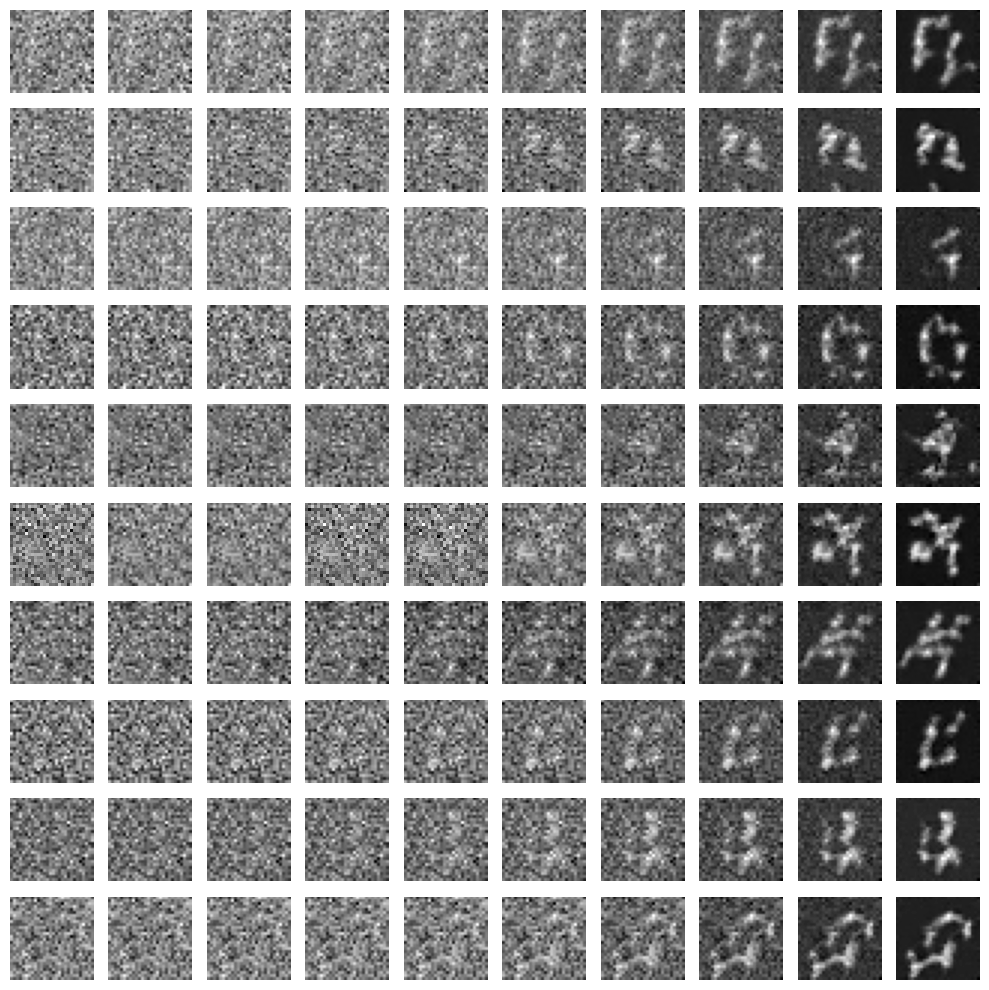

In [11]:
# show the image
fig, axs = plt.subplots(n_samples, n_eval, figsize=(n_eval, n_samples))

for i in range(n_samples):
    for j in range(n_eval):
        axs[i, j].imshow(out[j][i].squeeze().detach().numpy(), cmap='gray')
        axs[i, j].axis('off')
    
plt.tight_layout()
plt.show()